---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. You should NOT use Neural Network related classifiers (e.g., MLPClassifier) in this question. 

* Try to avoid global variables. If you have other functions besides blight_model, you should move those functions inside the scope of blight_model.

* Refer to the pinned threads in Week 4's discussion forum when there is something you could not figure it out.

# Import usual packages

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Loading data
I didn't use other data about gps and address because by correct data I can reach the requested accuracy (AUC)

In [21]:
train_df = pd.read_csv('readonly//train.csv',encoding = 'ISO-8859-1',low_memory=False)
test_df = pd.read_csv('readonly//test.csv',encoding = 'ISO-8859-1',low_memory=False)
train_df_without_nulls = train_df[train_df['compliance'].notnull()]


# Miss
here we can see which columns have miss and what is type of each column. Since we don't want do a complete modeling for each column which we decide to use, we solve missing problem.


In [4]:
print(train_df_without_nulls.info(),'\n\n')
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159880 entries, 0 to 250293
Data columns (total 34 columns):
ticket_id                     159880 non-null int64
agency_name                   159880 non-null object
inspector_name                159880 non-null object
violator_name                 159854 non-null object
violation_street_number       159880 non-null float64
violation_street_name         159880 non-null object
violation_zip_code            0 non-null float64
mailing_address_str_number    157322 non-null float64
mailing_address_str_name      159877 non-null object
city                          159880 non-null object
state                         159796 non-null object
zip_code                      159879 non-null object
non_us_str_code               3 non-null object
country                       159880 non-null object
ticket_issued_date            159880 non-null object
hearing_date                  159653 non-null object
violation_code                159880 non-null obj

# Understanding data

we consider the interesting relation I found here. There are more surely but we continue to reach the requested accuracy. Also, if we have some other opportunity we try to mention them.

[I could solve the problem just by one round of visualisation. unless I do it more carefully for these columns and other columns which I skipped.]

### Agency name
Agency has some effect on the "compliance". Probably it's because they show different type of violate. 

agency_name


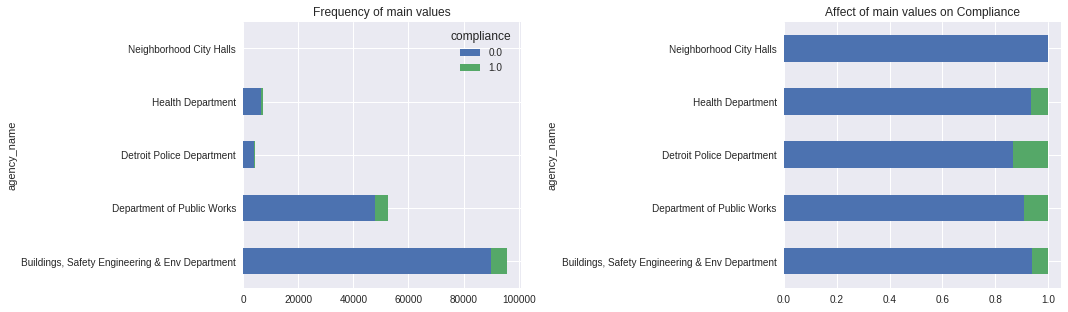

In [5]:
col='agency_name'
print(col)
if len(train_df[col].unique())<20:
    #plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4.5), tight_layout=True)
    df_plot1 = train_df.groupby([col, 'compliance']).size().reset_index().pivot(columns='compliance', index=col, values=0)
    df_plot1.plot(kind='barh', stacked=True,ax=ax1)
    ax1.set_title('Frequency of main values')
    df_plot2 = df_plot1.apply(lambda r:r/r.sum(),axis=1)
    df_plot2.plot(kind='barh', stacked=True,ax=ax2,legend=False)
    ax2.set_title('Affect of main values on Compliance')    
    plt.show()
else:
    print('too much unique value')

### Violator name

It seems some violator do their act several times. So, we can guess probably they should be relation between their decision and other decisions for compliance.

too much unique value


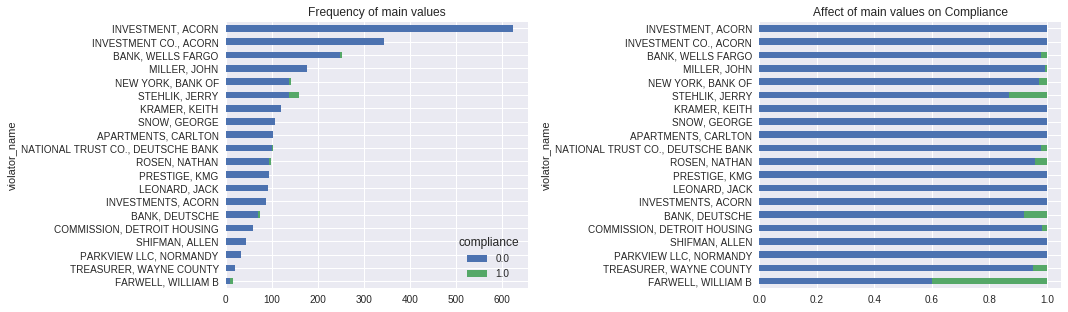

In [56]:
col='violator_name'
if len(train_df[col].unique())>20:
    print('too much unique value')
    new_train_df = train_df.copy()
    new_train_df = train_df[train_df[col].isin(list(train_df[col].value_counts().head(20).index))]#
else:
    new_train_df = train_df
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4.5), tight_layout=True)
df_plot1 = new_train_df.groupby([col, 'compliance']).size().reset_index().pivot(columns='compliance', index=col, values=0).sort_values(by=0.0)
df_plot1.plot(kind='barh', stacked=True,ax=ax1)
ax1.set_title('Frequency of main values')
df_plot2 = df_plot1.apply(lambda r:r/r.sum(),axis=1)
df_plot2.plot(kind='barh', stacked=True,ax=ax2,legend=False)
ax2.set_title('Affect of main values on Compliance')   
plt.show()


### Mailing_address_str_number 


About Address there are two aspect. First it's about same violator. It means there is a correlation between Address and Violator column. Second it's about a neighborhood. We have more columns and data source about neighborhood. we should cross check them with eachother and create a single clean column. however it needs much more time then other prepration and it's more than an assignment. We will consider this opportunity if we couldn't reach the requested accuracy.


mailing_address_str_number 

 NaN       3602
 213.0    1934
 1.0      1662
Name: mailing_address_str_number, dtype: int64
too much unique value


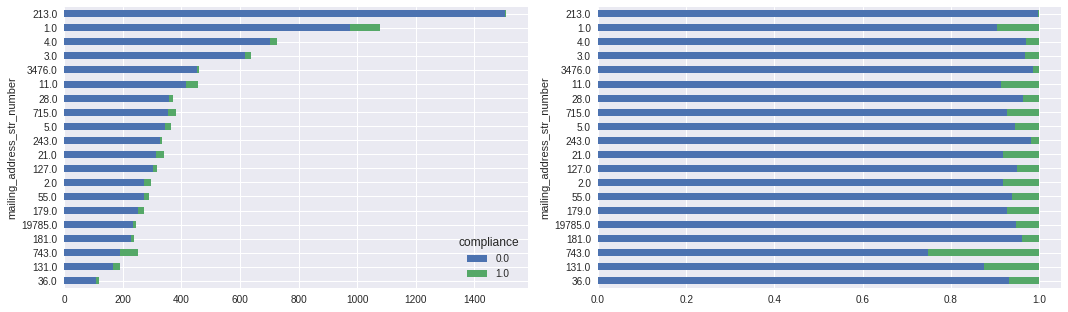

In [54]:
col='mailing_address_str_number'
print(col,'\n\n',train_df[col].value_counts(dropna=False).head(3))
if len(train_df[col].unique())>20:
    print('too much unique value')
    new_train_df = train_df.copy()
    new_train_df = train_df[train_df[col].isin(list(train_df[col].value_counts().head(20).index))]#
else:
    new_train_df = train_df
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4.5), tight_layout=True)
df_plot1 = new_train_df.groupby([col, 'compliance']).size().reset_index().pivot(columns='compliance', index=col, values=0).sort_values(by=0.0)
df_plot1.plot(kind='barh', stacked=True,ax=ax1)
df_plot2 = df_plot1.apply(lambda r:r/r.sum(),axis=1)
df_plot2.plot(kind='barh', stacked=True,ax=ax2,legend=False)
plt.show()


### Violation code

Similar to "violator name", we can add mean of "compliance" for other violations with the same code. It's important to clean the violation code before that because it has some noise in the code.


there are 235 unique values


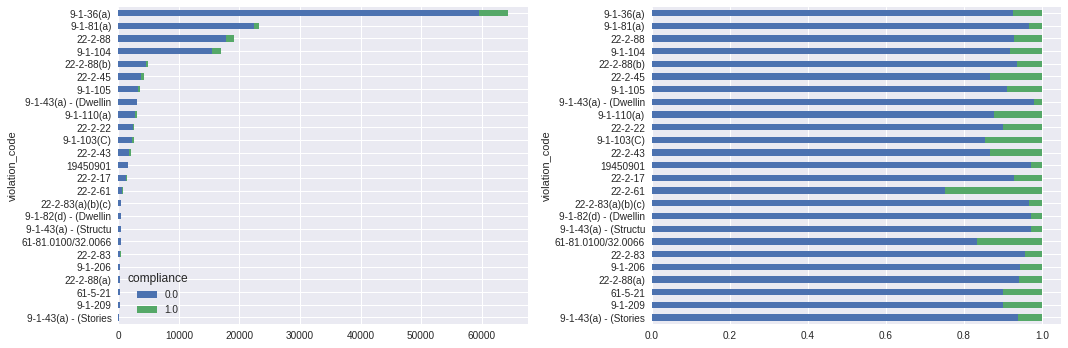

there are 194 unique values


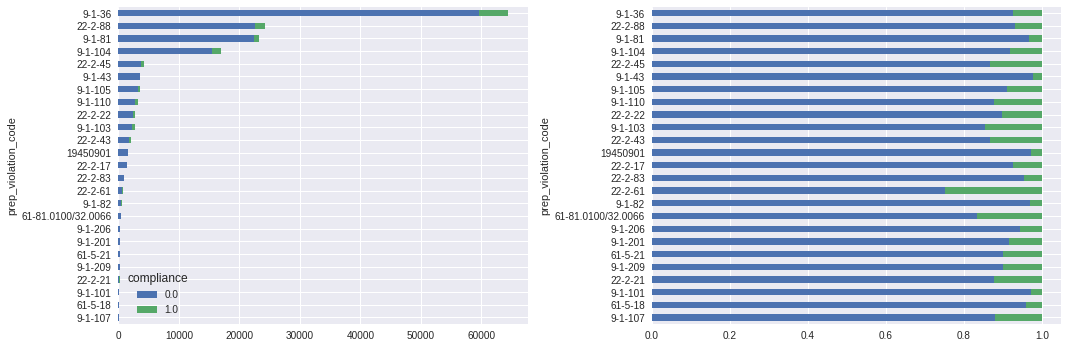

In [57]:
col='violation_code'

unq_cnt = len(train_df[col].unique())
if unq_cnt>20:
    print('there are {} unique values'.format(unq_cnt))
    #new_train_df = train_df[train_df[col].isin(list(train_df[col].value_counts().head(20).index))]#
    new_train_df = train_df.copy()
    #new_train_df.loc[:,col] = new_train_df[col].apply(lambda x:x[:4] if not pd.isnull(x) else 'null')
    new_train_df = train_df[train_df[col].isin(list(train_df[col].value_counts().head(25).index))]#

else:
    new_train_df = train_df
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)
df_plot1 = new_train_df.groupby([col, 'compliance']).size().reset_index().pivot(columns='compliance', index=col, values=0).sort_values(by=0.0)
df_plot1.plot(kind='barh', stacked=True,ax=ax1)
df_plot2 = df_plot1.apply(lambda r:r/r.sum(),axis=1)
df_plot2.plot(kind='barh', stacked=True,ax=ax2,legend=False)
plt.show()

#-------------------------------


def remove_tail(s,c):
    i=s.find(c)
    if i>0:
        return s[:i]
    else:
        return s

train_df['prep_violation_code']=train_df['violation_code'].apply(lambda x: remove_tail(remove_tail(x,' '),'('))

col='prep_violation_code'

unq_cnt = len(train_df[col].unique())
print('there are {} unique values'.format(unq_cnt))
new_train_df = train_df.copy()
new_train_df = train_df[train_df[col].isin(list(train_df[col].value_counts().head(25).index))]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)
df_plot1 = new_train_df.groupby([col, 'compliance']
                               ).size().reset_index().pivot(columns='compliance', index=col, values=0).sort_values(by=0.0)
df_plot1.plot(kind='barh', stacked=True,ax=ax1)
df_plot2 = df_plot1.apply(lambda r:r/r.sum(),axis=1)
df_plot2.plot(kind='barh', stacked=True,ax=ax2,legend=False)
plt.show()


### Violation description

It has too many item, but I have some Ideas to use violation description:
- combine with violation code and agency name
- doing text mining to reach a prediction. It will be weak lonely. but we can combine it with other method.
- extract main word by text mining and add them as features to our model.
- use description with more frequency

For first round I don't use it.

violation_description 

 Failure of owner to obtain certificate of compliance                                                    99091
Failure to obtain certificate of registration for rental property                                       43471
Failure of owner to keep property, its sidewalks, or adjoining public property free from solid waste    28719
Name: violation_description, dtype: int64
there are 258 unique values


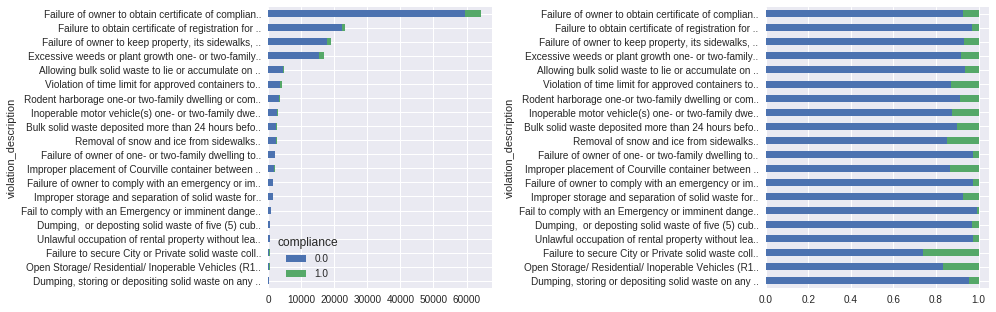

In [53]:
col=train_df.columns[17]
print(col,'\n\n',train_df[col].value_counts(dropna=False).head(3))
unq_cnt = len(train_df[col].unique())
if unq_cnt>20:
    print('there are {} unique values'.format(unq_cnt))
    #new_train_df = train_df[train_df[col].isin(list(train_df[col].value_counts().head(20).index))]#
    new_train_df = train_df.copy()
    #new_train_df.loc[:,col] = new_train_df[col].apply(lambda x:x[:4] if not pd.isnull(x) else 'null')
    new_train_df = train_df[train_df[col].isin(list(train_df[col].value_counts().head(20).index))]#

else:
    new_train_df = train_df
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5), tight_layout=True)
df_plot1 = new_train_df.groupby([col, 'compliance']).size().reset_index().pivot(columns='compliance', index=col, values=0).sort_values(by=0.0)
df_plot1.plot(kind='barh', stacked=True,ax=ax1)

labels = [item.get_text()[:50]+'..' for item in ax1.get_yticklabels()]
ax1.set_yticklabels(labels)

df_plot2 = df_plot1.apply(lambda r:r/r.sum(),axis=1)
df_plot2.plot(kind='barh', stacked=True,ax=ax2,legend=False)

ax2.set_yticklabels(labels)

plt.show()



### Disposition

current state of violator can be a very important feature. It has reasonable values. However we should solve Null problem because there are some value which we just have in test data.

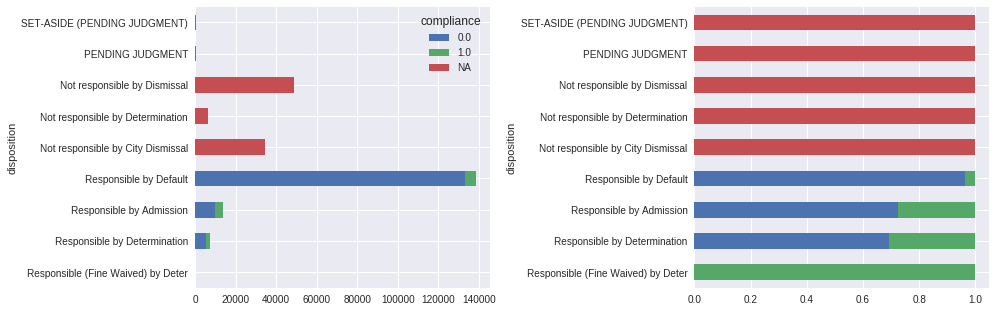

In [59]:
col='disposition'
unq_cnt = len(train_df[col].unique())
if unq_cnt>20:
    print('there are {} unique values'.format(unq_cnt))
    #new_train_df = train_df[train_df[col].isin(list(train_df[col].value_counts().head(20).index))]#
    new_train_df = train_df.copy()
    #new_train_df.loc[:,col] = new_train_df[col].apply(lambda x:x[:4] if not pd.isnull(x) else 'null')
    new_train_df = train_df[train_df[col].isin(list(train_df[col].value_counts().head(20).index))]#

else:
    new_train_df = train_df.copy()
new_train_df['compliance'].fillna('NA',inplace=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5), tight_layout=True)
df_plot1 = new_train_df.groupby([col, 'compliance']).size().reset_index().pivot(columns='compliance', index=col, values=0).sort_values(by=1.0)
df_plot1.plot(kind='barh', stacked=True,ax=ax1)

df_plot2 = df_plot1.apply(lambda r:r/r.sum(),axis=1)
df_plot2.plot(kind='barh', stacked=True,ax=ax2,legend=False)
plt.show()


### Fine amount
As we can see amount of fine has direct correlation to compliance. However, there are too many value and since the target value is binary it can rouine the model so we bined it.

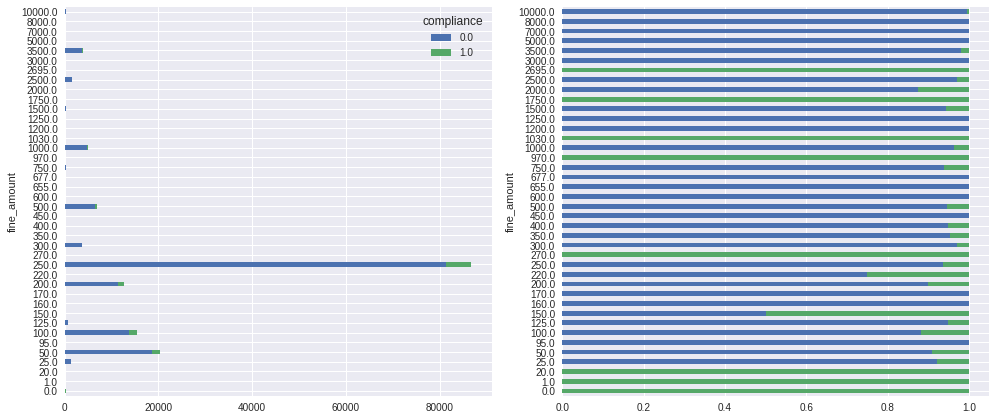

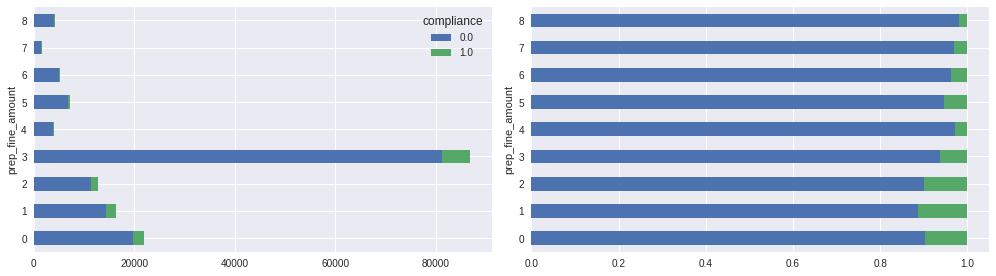

In [66]:
col='fine_amount'
new_train_df = train_df.copy()
#new_train_df['compliance'].fillna('NA',inplace=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)
df_plot1 = new_train_df.groupby([col, 'compliance']).size().reset_index().pivot(columns='compliance', index=col, values=0)
df_plot1.plot(kind='barh', stacked=True,ax=ax1)
df_plot2 = df_plot1.apply(lambda r:r/r.sum(),axis=1)
df_plot2.plot(kind='barh', stacked=True,ax=ax2,legend=False)
plt.show()


col='prep_fine_amount'
new_train_df = train_df.copy()
bins = [-1,75, 150, 225,275,400,750,1750,3000, np.inf]
new_train_df['prep_fine_amount'] = pd.cut(new_train_df['fine_amount'],bins, labels=range(len(bins)-1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), tight_layout=True)
df_plot1 = new_train_df.groupby([col, 'compliance']).size().reset_index().pivot(columns='compliance', index=col, values=0)
df_plot1.plot(kind='barh', stacked=True,ax=ax1)
df_plot2 = df_plot1.apply(lambda r:r/r.sum(),axis=1)
df_plot2.plot(kind='barh', stacked=True,ax=ax2,legend=False)
plt.show()


### Late fee
There is similar story with "fine amount" for this feature

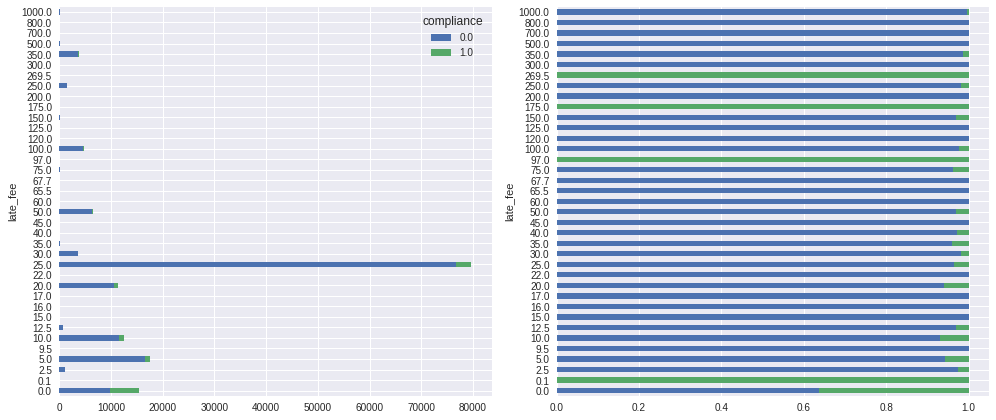

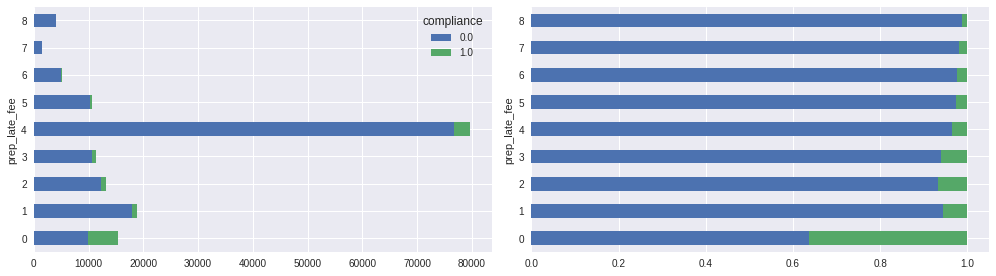

In [68]:
col='late_fee'
new_train_df = train_df.copy()
#new_train_df['compliance'].fillna('NA',inplace=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), tight_layout=True)
df_plot1 = new_train_df.groupby([col, 'compliance']).size().reset_index().pivot(columns='compliance', index=col, values=0)
df_plot1.plot(kind='barh', stacked=True,ax=ax1)
df_plot2 = df_plot1.apply(lambda r:r/r.sum(),axis=1)
df_plot2.plot(kind='barh', stacked=True,ax=ax2,legend=False)
plt.show()


col='prep_late_fee'
new_train_df = train_df.copy()
bins = [-1,0, 7.5, 15,22.5,27.5,75,175,300, np.inf]
new_train_df['prep_late_fee'] = pd.cut(new_train_df['late_fee'], bins, labels=range(len(bins)-1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), tight_layout=True)
df_plot1 = new_train_df.groupby([col, 'compliance']).size().reset_index().pivot(columns='compliance', index=col, values=0)
df_plot1.plot(kind='barh', stacked=True,ax=ax1)
df_plot2 = df_plot1.apply(lambda r:r/r.sum(),axis=1)
df_plot2.plot(kind='barh', stacked=True,ax=ax2,legend=False)
plt.show()

### Discount amount
It's obvioues which this feature is important. However there are lot's of different value for discount and all of them have same behaviour. So, we decide to create a new feature which say Is there any discount or not.

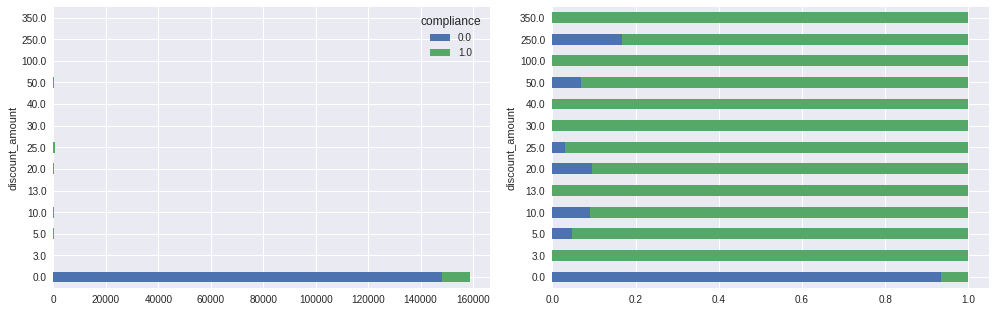

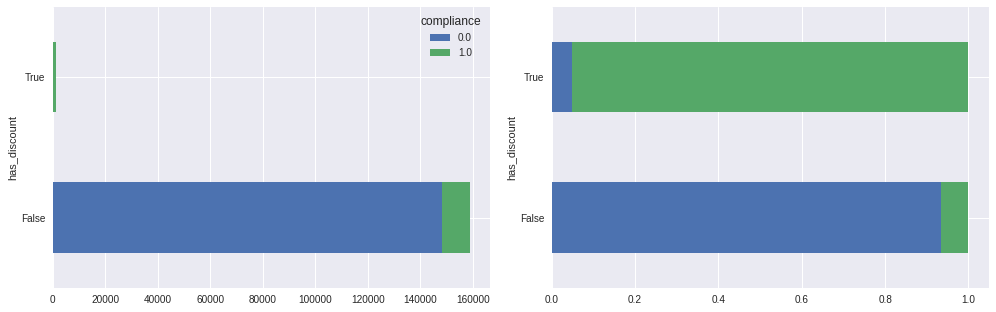

In [70]:
col='discount_amount'
new_train_df = train_df.copy()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5), tight_layout=True)
df_plot1 = new_train_df.groupby([col, 'compliance']).size().reset_index().pivot(columns='compliance', index=col, values=0)
df_plot1.plot(kind='barh', stacked=True,ax=ax1)
df_plot2 = df_plot1.apply(lambda r:r/r.sum(),axis=1)
df_plot2.plot(kind='barh', stacked=True,ax=ax2,legend=False)
plt.show()


col='has_discount'
new_train_df = train_df.copy()
new_train_df['has_discount']=new_train_df['discount_amount']>0
#new_train_df['compliance'].fillna('NA',inplace=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5), tight_layout=True)
df_plot1 = new_train_df.groupby([col, 'compliance']).size().reset_index().pivot(columns='compliance', index=col, values=0)
df_plot1.plot(kind='barh', stacked=True,ax=ax1)
df_plot2 = df_plot1.apply(lambda r:r/r.sum(),axis=1)
df_plot2.plot(kind='barh', stacked=True,ax=ax2,legend=False)
plt.show()


### compliance detail
Maybe we can use this feature to find out where is the problem of our classifier.

compliance_detail 

 non-compliant by no payment                        129267
not responsible by disposition                      89735
non-compliant by late payment more than 1 month     19016
Name: compliance_detail, dtype: int64


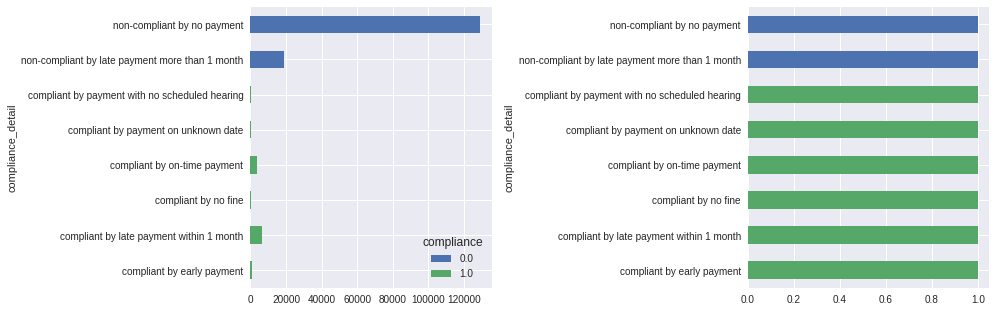

In [72]:
col=train_df.columns[32]
print(col,'\n\n',train_df[col].value_counts(dropna=False).head(3))
unq_cnt = len(train_df[col].unique())
if unq_cnt>20:
    print('there are {} unique values'.format(unq_cnt))
    #new_train_df = train_df[train_df[col].isin(list(train_df[col].value_counts().head(20).index))]#
    new_train_df = train_df.copy()
    #new_train_df.loc[:,col] = new_train_df[col].apply(lambda x:x[:4] if not pd.isnull(x) else 'null')
    new_train_df = train_df[train_df[col].isin(list(train_df[col].value_counts().head(20).index))]#

else:
    new_train_df = train_df
#new_train_df['compliance'].fillna('NA',inplace=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5), tight_layout=True)
df_plot1 = new_train_df.groupby([col, 'compliance']).size().reset_index().pivot(columns='compliance', index=col, values=0)
df_plot1.plot(kind='barh', stacked=True,ax=ax1)

df_plot2 = df_plot1.apply(lambda r:r/r.sum(),axis=1)
df_plot2.plot(kind='barh', stacked=True,ax=ax2,legend=False)
plt.show()


# Preparation

### Compliance of a violator in other cases
As we explained before we are going to calculate the mean of Compliance for a violator in other cases. There is some points which we should consider:
- we shouldn't use the current compliance in our calculation.
- we should define a proper value for violator which just do it once. We fill it with 0.5
- we should reduce the impact of the case which has less other cases. We add a 0.5 to thier compliance collection.
- we shouldn't use future cases for calculate currect case. I didn't obey this rule. It reduce my model accuracy but it doesn't mean leakage because all test dataset is occur after train dataset. (It makes development much harder. I decided to skip it in first phase)

## preparation function
I defined a preparation function so I can preparate my train and test dataset separately. In this function:
- defined the columns we should use for modeling (return_col)
- converted agency to number
- converted disposition to probability and fill nulls general probability of compliance, because I don't have enough information about possible null.
- bined fine amount
- bined late fee
- create "has_discount" from discount_amount


In [39]:
def preparating_data(df,vn_others=0,vc_others=0):

    for i in df[df.violator_name.isnull()].index:
        df.loc[i,'violator_name']='Null'+str(i)
    if type(vn_others)==int:
        df['violator_other_time'] = df[['violator_name','compliance']
                     ].merge(df.groupby(['violator_name'])['compliance'].agg(['sum','size']),
                             left_on='violator_name',
                             right_index=True).apply(lambda r:(r['sum']-r['compliance']+0.5)/r['size'], axis=1)
        vn_others = df.groupby(['violator_name'])['violator_other_time'].agg('max').to_frame()
    else:
        df =df.merge(vn_others,
                                 left_on='violator_name',
                                 right_index=True,
                                 how='left').fillna(0.5)

    def remove_tail(s,c):
        i=s.find(c)
        if i>0:
            return s[:i]
        else:
            return s
        
    df['prep_violation_code']=df['violation_code'].apply(lambda x: remove_tail(remove_tail(x,' '),'('))

    if type(vc_others)==int:
        df['violation_code_others'] = df[['prep_violation_code','compliance']
                     ].merge(df.groupby(['prep_violation_code'])['compliance'].agg(['sum','size']),
                             left_on='prep_violation_code',
                             right_index=True).apply(lambda r:(r['sum']-r['compliance']+0.5)/r['size'], axis=1)
        vc_others = df.groupby(['prep_violation_code'])['violation_code_others'].agg('max').to_frame()
    else:
        df =df.merge(vc_others,
                             left_on='prep_violation_code',
                             right_index=True,
                             how='left').fillna(0.5)
    return_col=['violator_other_time','violation_code_others']    
    
    df['ag_Env']=(df.agency_name=='Buildings, Safety Engineering & Env Department')+0
    df['ag_works']=(df.agency_name=='Department of Public Works')+0
    #df['ag_Health']=(df.agency_name=='Health Department')+0 #because we don't have health in test and the other value just have two case we remove this
    df['ag_Police']=(df.agency_name=='Detroit Police Department')+0
    return_col += ['ag_Env','ag_works','ag_Police']

    df['disp_Default'] = (df.disposition == 'Responsible by Default')+0        
    df['disp_Admission'] = (df.disposition == 'Responsible by Admission')+0
    df['disp_Determination'] = (df.disposition == 'Responsible by Determination')+0
    df['disp_Deter'] = (df.disposition == 'Responsible (Fine Waived) by Deter')+0
    return_col +=['disp_Default','disp_Admission','disp_Determination','disp_Deter']
    

    bins = [-1,75, 150, 225,275,400,750,1750,3000, np.inf]
    df['prep_fine_amount'] = pd.cut(df['fine_amount'],bins, labels=range(len(bins)-1))
    df['prep_fine_amount'] = (df['prep_fine_amount']-df['prep_fine_amount'].min()
                             )/(df['prep_fine_amount'].max()-df['prep_fine_amount'].min())
    return_col += ['prep_fine_amount']


    bins = [-1,0, 7.5, 15,22.5,27.5,75,175,300, np.inf]
    df['prep_late_fee'] = pd.cut(df['late_fee'], bins, labels=range(len(bins)-1))
    df['prep_late_fee'] = (df['prep_late_fee']-df['prep_late_fee'].min()
                             )/(df['prep_late_fee'].max()-df['prep_late_fee'].min())
    return_col += ['prep_late_fee']

    
    df['has_discount']=(df['discount_amount']>0)+0
    return_col += ['has_discount']
    
    return df[return_col],vn_others,vc_others

# Modeling

In [40]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


### split data to train and test and then preparate data

In [41]:
X_train, X_test, y_train, y_test = train_test_split(train_df_without_nulls, 
                                                    train_df_without_nulls['compliance'], random_state=0)
X_train_p,vn_others,vc_others = preparating_data(X_train)
X_test_p,_,_ = preparating_data(X_test,vn_others,vc_others)

### create polynominal Features

In [44]:
poly = PolynomialFeatures(degree = 2) 
X_train_poly = poly.fit_transform(X_train_p) 
X_test_poly = poly.fit_transform(X_test_p) 

### Logistic Regression

In [45]:
lrc = LogisticRegression(penalty='l2',C=1000)
lrc.fit(X_train_poly,y_train)

print('Accuracy:',lrc.score(X_test_poly,y_test))

probs = lrc.predict_proba(X_test_poly)
probs = probs[:, 1]
print('AUC:',roc_auc_score(y_test,probs))
#print(poly.get_feature_names())
#print(lrc.coef_)
#pd.DataFrame(list(zip(poly.get_feature_names(),lrc.coef_[0]))).sort_values(by=1)

Accuracy: 0.943557668251
AUC: 0.833638197917
